In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn.functional as F

from tools.display import extract_minutiae_from_map, draw_minutiae_on_image
from DeepPrint.pretrained import GridSampler

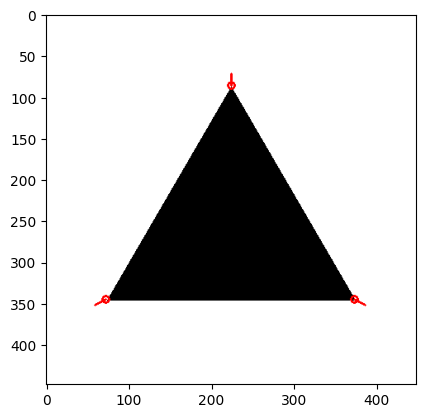

In [ ]:
# minutiae = np.load('minutiae.npy')
triangle = np.load('triangle.npy')
triangle = cv2.cvtColor(triangle, cv2.COLOR_BGR2GRAY)
mmap = np.load('mmap.npy')

def plot_image_and_map(img, mmap):
    extracted_minutiae = extract_minutiae_from_map(mmap, 0.5, 15)
    out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    out = draw_minutiae_on_image(out, extracted_minutiae, mmap.shape[:2], triangle.shape[:2])
    plt.imshow(out)

plot_image_and_map(triangle, mmap)

In [112]:
def plot_minutiae_map(H):
    """
    Display a 6-channel minutiae map as a 3x2 grid.
    Args:
        H: np.ndarray of shape (H, W, 6)
    """
    fig, axes = plt.subplots(2, 3, figsize=(6, 8))
    for i in range(6):
        ax = axes[i%2, i//2]
        ax.imshow(H[..., i], cmap='hot')
        ax.set_title(f'Channel {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.00003].


0.00014283923 [(np.int64(160), np.int64(148), np.float32(5.766249)), (np.int64(31), np.int64(148), np.float32(3.658529)), (np.int64(96), np.int64(37), np.float32(1.5707964))]
0.00013762696030257586 [(np.int64(164), np.int64(138), np.float64(6.15614245110949)), (np.int64(42), np.int64(182), np.float64(4.057563892958247)), (np.int64(65), np.int64(55), np.float64(1.9652663226176976))]


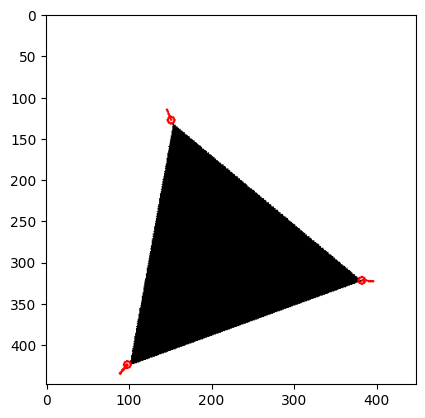

In [125]:
dx = 70
dy = -50
dt = math.pi/9.

def apply_affine_to_img(img_np, dx, dy, dt):
    # Convert to torch tensor and add batch/channel dims
    img_tensor = torch.from_numpy(img_np).float().unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    H, W = img_tensor.shape[-2:]

    tx = dx / W
    ty = dy / H
    theta = dt

    cos_theta = torch.cos(torch.tensor(theta))
    sin_theta = torch.sin(torch.tensor(theta))

    # Affine matrix: [1, 2, 3]
    affine = torch.tensor([[[cos_theta, -sin_theta, tx],
                            [sin_theta,  cos_theta, ty]]], dtype=torch.float)

    grid = F.affine_grid(affine, img_tensor.size(), align_corners=False)
    out = F.grid_sample(img_tensor, grid, align_corners=False, padding_mode='border')
    return out.squeeze().numpy()  # Remove batch/channel dims and return NumPy

def rotate_orientation_channels(mmap_rotated, delta_theta):
    """
    Rotates orientation bins of a 6-channel map by delta_theta radians.
    mmap_rotated: (H, W, 6) — already spatially rotated
    """
    H, W, C = mmap_rotated.shape
    assert C == 6

    # Compute relative circular shift
    bin_shift = -6 * delta_theta / (2 * np.pi)  # negative = CCW rotation

    # Circular interpolation along channel axis
    fft = np.fft.fft(mmap_rotated, axis=2)
    freqs = np.fft.fftfreq(C)[:, None, None]  # shape (6, 1, 1)
    phase = np.exp(2j * np.pi * freqs * bin_shift)
    fft_shifted = fft * phase.T  # transpose for broadcasting
    mmap_rotated_oriented = np.fft.ifft(fft_shifted, axis=2).real

    return mmap_rotated_oriented

def apply_affine_to_map(mmap_np, dx, dy, dt, img_shape=(448, 448)):
    H, W, C = mmap_np.shape
    assert C == 6, "Expected 6 channels in minutiae map"

    # Convert to [1, 6, H, W] tensor
    mmap_tensor = torch.from_numpy(mmap_np).float().permute(2, 0, 1).unsqueeze(0)  # [1, 6, H, W]

    ih, iw = img_shape
    tx = dx / iw
    ty = dy / ih    
    theta = dt

    cos_theta = torch.cos(torch.tensor(theta))
    sin_theta = torch.sin(torch.tensor(theta))

    affine = torch.tensor([[[cos_theta, -sin_theta, tx],
                            [sin_theta,  cos_theta, ty]]], dtype=torch.float)
    # affine = torch.tensor([[[1.0, 0.0, tx],
    #                         [0.0, 1.0, ty]]], dtype=torch.float)

    grid = F.affine_grid(affine, mmap_tensor.size(), align_corners=False)
    transformed = F.grid_sample(mmap_tensor, grid, mode='nearest', align_corners=False)

    # Convert back to [H, W, 6]
    # return transformed.squeeze(0).permute(1, 2, 0).numpy()
    return rotate_orientation_channels(
        transformed.squeeze(0).permute(1, 2, 0).numpy(), dt
    )


rot_img = apply_affine_to_img(triangle, dx, dy, dt)
rot_map = apply_affine_to_map(mmap, dx, dy, dt)

print(mmap.mean(), extract_minutiae_from_map(mmap, 0.5, 15))
print(rot_map.mean(), extract_minutiae_from_map(rot_map, 0.4, 15))

plot_image_and_map(rot_img, rot_map)